# Using tensorflow to infer what features of animals are present in the image

The following codeblock is extracted from `load_ontology.ipynb`

In [1]:
import owlready2
import itertools
import numpy
import scipy
import typing

# Returns the mapping dictionary from species name to feature vector,
# a function that returns the closest species given a feature vector,
# and the names of each feature.
def load_features_mapping(
    iri: str = "https://raw.githubusercontent.com/Flo3171/DS51_Project/master/code/animal_ontologie.rdf#"
) -> typing.Tuple[
    dict[str, numpy.array],
    typing.Callable[[numpy.array], str | None],
    dict[str, str],
    dict[int, str]
]:
    animals_onto = owlready2.get_ontology(iri).load()

    properties = set(animals_onto.search(subproperty_of = animals_onto["a_pour_caractéristique"]))
    animal_features = dict()

    for animal in animals_onto.search(subclass_of = animals_onto["Animal"]):
        if animal == animals_onto["Animal"]:
            continue
        
        animal_features[animal.name] = set()
        # Prop is for instance `a_sur_la_peau`
        for prop in animal.get_class_properties():
            if not (prop in properties):
                continue
            # Get the restriction defined for the class, for instance `Fourrure`
            prop_range_restriction = prop[animal]
            assert len(prop_range_restriction) == 1
            feature = prop_range_restriction[0].name
            # store it
            animal_features[animal.name].add(feature)

    # Get the list of all features found
    all_features = set(itertools.chain.from_iterable(animal_features.values()))
    
    # Extract the identifiers in the dataset for the class
    dataset_identifiers = dict()
    identifier_prop = animals_onto["a_pour_identifiant"]
    for animal in animals_onto.search(subclass_of = animals_onto["Animal"]):
        for identifier in identifier_prop[animal]:
            dataset_identifiers[identifier] = animal.name

    # Assign numbers to each caracteristic
    feature_indices = dict(enumerate(all_features))

    # Generate the class name -> feature vector dict
    def get_vector(features: set[str]) -> list[int]:
        res = numpy.zeros(len(all_features))
        for index, name in feature_indices.items():
            if name in features:
                res[index] = 1

        return res

    feature_dict = {name: get_vector(features) for name, features in animal_features.items()}

    names_list = list(feature_dict.keys())
    features_list = numpy.array(list(feature_dict.values()))

    def get_animal_from_features2(input_features: list[float]) -> str | None:
        dists = scipy.spatial.distance.cdist(features_list, [input_features], metric="euclidean")

        return names_list[numpy.argmin(dists)]

    return (feature_dict, get_animal_from_features2, dataset_identifiers, feature_indices)

In [2]:
import tensorflow as tf

def apply_species_features(
    dataset: tf.data.Dataset,
    features: dict[str, numpy.array],
    identifiers: dict[str, str] | None = None
) -> tf.data.Dataset:
    class_names = dataset.class_names
    features = {key: tf.convert_to_tensor(value, dtype="float32") for key, value in features.items()}
    n_features = len(features[list(features.keys())[0]])

    def get_vector(index: int) -> tf.Tensor:
        identifier = class_names[index]

        if identifiers != None:
            return features[identifiers[identifier]]
        else:
            return features[identifier]

    vectors = tf.convert_to_tensor(list(map(get_vector, range(len(class_names)))))

    return dataset.map(lambda data, labels:
        (data, tf.nn.embedding_lookup(vectors, labels)),
    )

2023-06-16 21:09:23.307939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Explore the directory

In [3]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_img(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(256, 256))
    return image

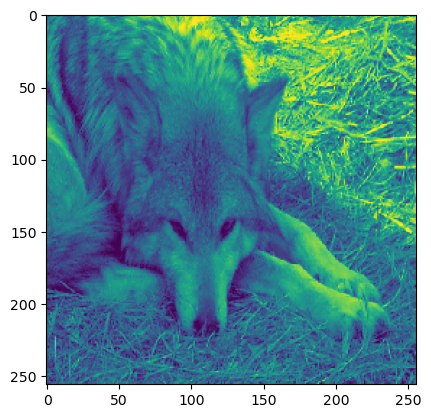

In [4]:
import matplotlib.pyplot as plt

image = load_and_scale_img('../dataset/ILSVRC/Data/CLS-LOC/train/n02114367/n02114367_106.JPEG')
plt.imshow(image)

## Attempt 1 : Small model

The input shape of our network will be of $256 \times 256$. Thus we will reshape every image to a unified size of $256 \times 256$ pixels.

### Load the data

Here we use a built in Tensorflow function : `tf.keras.preprocessing.image_dataset_from_directory()` that load a directory where each folder is a class containing images belonging to it. 

In [10]:
import tensorflow as tf
import os

dataset_path = os.path.abspath('../dataset/ILSVRC/Data/CLS-LOC/train')

seed = 42
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, shuffle=True, validation_split=0.01, subset="training", seed=seed, batch_size=16)
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, shuffle=True, validation_split=0.01, subset="validation", seed=seed, batch_size=16)


Found 7800 files belonging to 6 classes.
Using 7722 files for training.
Found 7800 files belonging to 6 classes.
Using 78 files for validation.


Next, we modify the dataset to contain the feature vectors:

In [24]:
owlready2.onto_path.append(os.path.abspath("."))
feature_dict, get_animal_from_features2, dataset_identifiers, feature_indices = load_features_mapping()

dataset_transformed = apply_species_features(dataset, feature_dict, dataset_identifiers)
dataset_test_transformed = apply_species_features(dataset_test, feature_dict, dataset_identifiers)

In [7]:
for data, labels in dataset_transformed.take(1):
    print(data.shape)
    print(labels.shape)


2023-06-16 20:44:10.890621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype float and shape [6,8]
	 [[{{node Placeholder/_17}}]]
2023-06-16 20:44:10.891277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7722]
	 [[{{node Placeholder/_0}}]]


(32, 256, 256, 3)
(32, 8)


`tf.data.Dataset.take(count)` creates a Dataset with at most `count` elements from this Dataset.


2023-06-16 20:53:46.072637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7722]
	 [[{{node Placeholder/_4}}]]
2023-06-16 20:53:46.072959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7722]
	 [[{{node Placeholder/_4}}]]


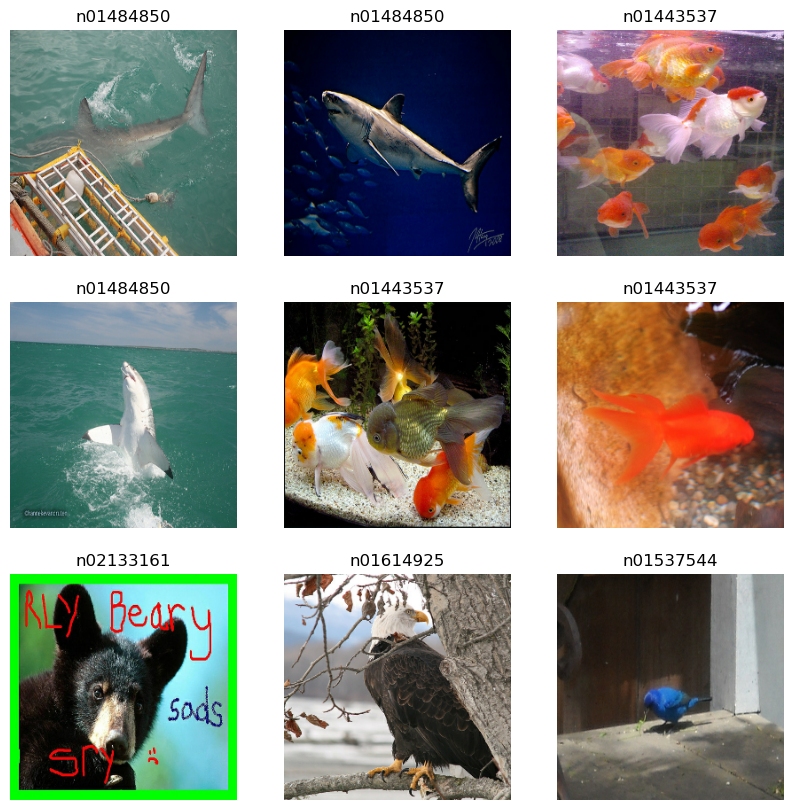

In [5]:
import matplotlib.pyplot as plt

class_names = dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Create the Model

Here, we use a small convolutional neural network.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    SpatialDropout2D,
    Add,
)

num_classes = 10

model = Sequential()
model.add(Conv2D(32, (5, 5), strides=1, padding="same", activation="relu",
                 input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((3, 3), strides=3, padding="same"))
model.add(Conv2D(32, (5, 5), strides=1, padding="same", activation="relu"))
model.add(SpatialDropout2D(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((3, 3), strides=3, padding="same"))
model.add(Conv2D(32, (5, 5), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((5, 5), strides=5, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=len(feature_indices), activation="softmax"))


In [12]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 batch_normalization_3 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 32)        25632     
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 86, 86, 32)       0         
 lDropout2D)                                                     
                                                      

In [17]:
model.fit(dataset_transformed,
          epochs=5,
          validation_data=dataset_test_transformed,
          verbose=2,
)


Epoch 1/5


483/483 - 32s - loss: 0.2361 - accuracy: 0.3644 - 32s/epoch - 67ms/step
Epoch 2/5
483/483 - 32s - loss: 0.2175 - accuracy: 0.3548 - 32s/epoch - 67ms/step
Epoch 3/5
483/483 - 32s - loss: 0.1933 - accuracy: 0.3625 - 32s/epoch - 67ms/step
Epoch 4/5
483/483 - 32s - loss: 0.1888 - accuracy: 0.3639 - 32s/epoch - 67ms/step
Epoch 5/5
483/483 - 32s - loss: 0.1831 - accuracy: 0.3724 - 32s/epoch - 67ms/step


## Attempt 2 : data augmentation and skip connections

Here, we use a generator to perform data augmentation on our original dataset. That is, each image will be slightly altered before being fed in to the model. 

In [3]:
import tensorflow as tf
import os
dataset_path = os.path.abspath('../dataset/ILSVRC/Data/CLS-LOC/train')

In [12]:
augmentation_step = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    # tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])
aug_dataset = dataset_transformed.map(lambda data, labels: (augmentation_step(data), labels))

### Create the model

We are using a more advanced convolutional neural network to analyze our data.

In [33]:
def residual_conv_model(size: int):
    from tensorflow.keras import layers
    
    layer_input = layers.Input(shape=(256, 256, 3))
    
    conv_1 = layers.Conv2D(size, (5, 5), strides=1, padding="same", activation="relu")(layer_input)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_1 = layers.SpatialDropout2D(0.2)(conv_1)
    conv_1 = layers.MaxPool2D((3, 3), padding="same")(conv_1)

    skip_2 = layers.BatchNormalization()(conv_1)
    conv_2 = layers.Conv2D(size, (5, 5), strides=1, padding="same", activation="relu")(conv_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_2 = layers.Add()([conv_2, skip_2])
    # conv_2 = layers.Conv2D(size, (3, 3), strides=3, padding="same", activation="relu")(conv_2)
    conv_2 = layers.MaxPool2D((3, 3), padding="same")(conv_2)
    conv_2 = layers.SpatialDropout2D(0.2)(conv_2)

    skip_3 = layers.BatchNormalization()(conv_2)
    conv_3 = layers.Conv2D(size, (5, 5), strides=1, padding="same", activation="relu")(conv_2)
    conv_3 = layers.BatchNormalization()(conv_3)
    conv_3 = layers.Add()([conv_3, skip_3])
    # conv_3 = layers.Conv2D(size, (3, 3), strides=3, padding="same", activation="relu")(conv_3)
    conv_3 = layers.MaxPool2D((3, 3), padding="same")(conv_3)
    conv_3 = layers.SpatialDropout2D(0.2)(conv_3)
    
    flattened = layers.Flatten()(conv_3)
    
    dense_1 = layers.Dense(units=256, activation="relu")(flattened)
    dense_1 = layers.Dropout(0.3)(dense_1)
    
    dense_2 = layers.Dense(units=len(feature_indices), activation="softmax")(dense_1)
    
    return tf.keras.Model(layer_input, dense_2)

model = residual_conv_model(64)


In [34]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 64  4864        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 256, 256, 64  256        ['conv2d_24[0][0]']              
 ormalization)                  )                                                           

In [36]:
model.fit(aug_dataset,
          epochs=5,
          validation_data=dataset_test_transformed,
        #   verbose=2,
)
# 0.3077

Epoch 1/5
483/483 [==============================] - 142s 293ms/step - loss: 0.4701 - accuracy: 0.2414 - val_loss: 0.3863 - val_accuracy: 0.2179
Epoch 2/5
483/483 [==============================] - 139s 288ms/step - loss: 0.3563 - accuracy: 0.2488 - val_loss: 0.2403 - val_accuracy: 0.2949
Epoch 3/5
483/483 [==============================] - 140s 290ms/step - loss: 0.3362 - accuracy: 0.2282 - val_loss: 0.2455 - val_accuracy: 0.1795
Epoch 4/5
483/483 [==============================] - 141s 291ms/step - loss: 0.3057 - accuracy: 0.2154 - val_loss: 0.1891 - val_accuracy: 0.2564
Epoch 5/5
483/483 [==============================] - 138s 285ms/step - loss: 0.2964 - accuracy: 0.2148 - val_loss: 0.2270 - val_accuracy: 0.0897


It seems like the benefits of having skip connections are outweighed by the added cost of training the network.

### Save the Model

We can save the model to later reuse it.

In [7]:
model.save('image_net_cnn1')

INFO:tensorflow:Assets written to: image_net_cnn1/assets


INFO:tensorflow:Assets written to: image_net_cnn1/assets


Use the following cell to load the model

In [8]:
from tensorflow import keras
model = keras.models.load_model('image_net_cnn1')